In [12]:
from typing import TypedDict
from langgraph.graph import StateGraph

In [13]:
# We now create an AgentState - shared data structure that keeps track of information as your application runs. 

class AgentState(TypedDict): # Our state schema
    name : str 


def compliment_node(state: AgentState) -> AgentState:
    """Simple node that compliments the user"""

    state['name'] = state["name"] + " you're doing an amazing job learning LangGraph!"

    return state 

In [14]:
graph = StateGraph(AgentState)

graph.add_node("compliment", compliment_node)

graph.set_entry_point("compliment")
graph.set_finish_point("compliment")

app = graph.compile()

In [14]:
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
from IPython.display import Image, display
import nest_asyncio

nest_asyncio.apply()  # Allow async code in Jupyter

def show_graph(graph):
    """Display the graph in Jupyter Notebook"""
    display(
        Image(
            graph.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.PYPPETEER,
                background_color="white", padding=10
            )
        )
    )

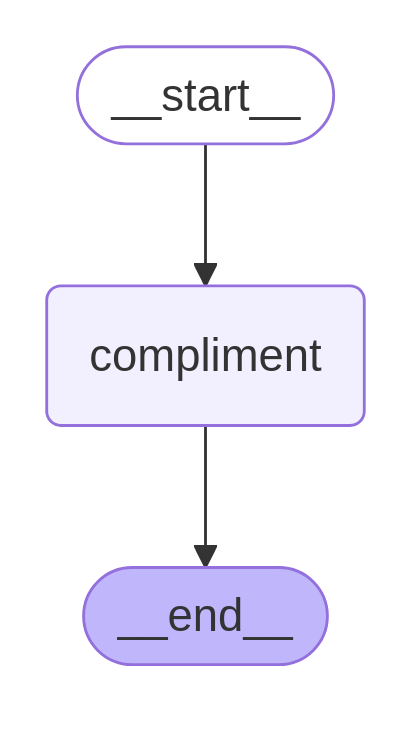

In [16]:
show_graph(app)

In [17]:
result = app.invoke({"name": "Bob"})

In [18]:
result["name"]

"Bob you're doing an amazing job learning LangGraph!"

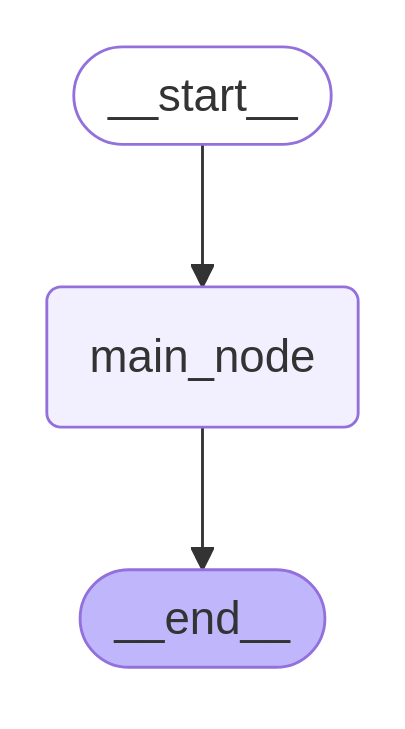

In [19]:
from typing import Literal

class State(TypedDict):
    name: str
    num_list : list[int]
    operation: Literal['*', '+']
    answer: int    
    

def main_node(state: State) -> State:
    """Main node that performs an operation on a list of numbers"""
    operation = state["operation"]
    result = None
    if operation == "+":
        result = 0
    elif operation == "*":
        result = 1
    else:
        print("Invalid operation!")
        exit(1)
    
    for num in state["num_list"]:
        if operation == "+":
            result += num
        elif operation == "*":
            result *= num
            
    return {
        "name": state["name"],
        "num_list": state["num_list"],
        "operation": state["operation"],
        "answer": result
    }            
    
builder = StateGraph(State)

builder.add_node("main_node", main_node)
builder.set_entry_point("main_node")
builder.set_finish_point("main_node")

graph = builder.compile()

show_graph(graph)
    

In [ ]:
result = graph.invoke({"name": "Jack Sparrow", "num_list": [1,2,3,4], "operation": "*"})

# Fix: Check if result is a dict before accessing keys
if isinstance(result, dict) and "name" in result and "answer" in result:
    print(f"Hi {result['name']}, your answer is {result['answer']}.")
else:
    print(f"Unexpected result: {result}")

Hi Jack Sparrow, your answer is 24.


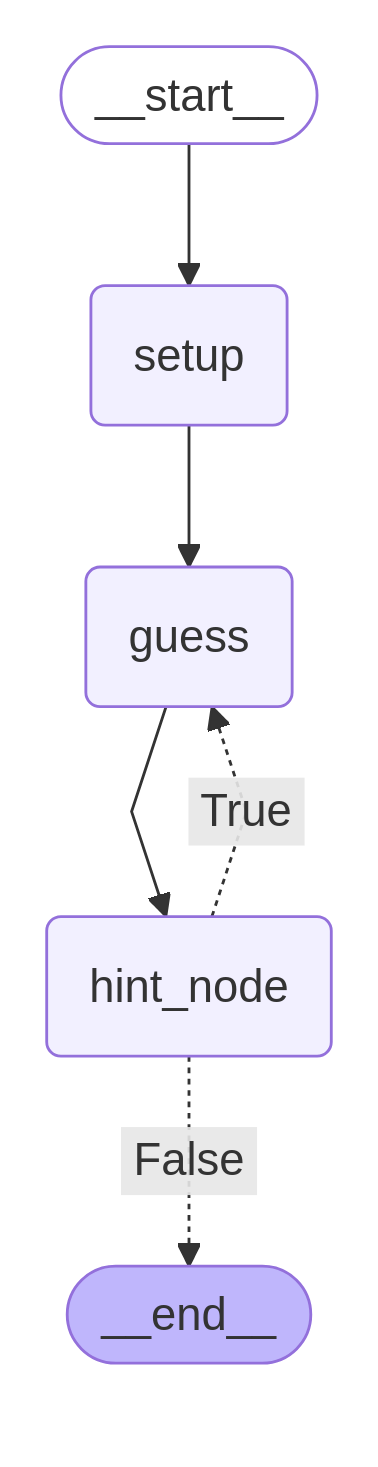

Making guess... 14  Attempt number: 1
The answer is lower than your answer:14...
Making guess... 11  Attempt number: 2
The answer is higher than your answer:11...
Making guess... 13  Attempt number: 3
{'player_name': 'Yasir', 'guesses': [14, 11, 13], 'attempts': 3, 'lower_bound': 12, 'upper_bound': 13, 'answer': 13, 'hint': 'You got it', 'result': 'Hey Yasir, you have got it!\nThe answer is: 13'}


In [21]:
from random import randint
from langgraph.graph import END


class AgentState(TypedDict):
    player_name: str
    guesses: list[int]
    attempts: int
    lower_bound: int
    upper_bound: int
    answer: int
    hint: Literal["You got it", "lower", "higher"]
    result: str
    
# setup node
def setup(state: AgentState) -> AgentState:
    state['answer'] = randint(state['lower_bound'], state['upper_bound'])
    state['guesses'] = []
    state['result'] = "You couldn't make it, you exceeded 7 trials.\nThe answer is " + str(state["answer"])
    state["attempts"] = 0
    return state

# guess node
def make_guess(state: AgentState) -> AgentState:
    guess = randint(state['lower_bound'], state['upper_bound'])
    state['guesses'].append(guess)
    state['attempts'] += 1
    print(f"Making guess... {guess}" + "  Attempt number: " + str(state["attempts"]))
    return state

# hint node
def hint(state: AgentState) -> AgentState:
    guess = state['guesses'][state['attempts']-1]
    if guess == state['answer']:
        state['hint'] = "You got it"
        state['result'] = f"Hey {state['player_name']}, you have got it!\nThe answer is: {state['answer']}"
    elif guess > state['answer']:
        state['hint'] = "lower"
        state["upper_bound"] = guess - 1
    else:
        state['hint'] = "higher"
        state['lower_bound'] = guess + 1
    return state
        

# condition function
def check_continue(state: AgentState) -> AgentState:
    guess = state['guesses'][state['attempts']-1]
    if state["attempts"] > 7:
        return False
    
    elif state["hint"] == "You got it":
        return False
    
    elif state["hint"] == "lower":
        print("The answer is lower than your answer:" + str(guess) + "...")
        
    elif state["hint"] == "higher":
        print("The answer is higher than your answer:" + str(guess) + "...")
        
    return True


builder = StateGraph(AgentState)


builder.add_node("setup", setup)
builder.add_node("guess", make_guess)
builder.add_node("hint_node", hint)

builder.set_entry_point("setup")
builder.set_finish_point("hint_node")

builder.add_edge("setup", "guess")
builder.add_edge("guess", "hint_node")
builder.add_conditional_edges("hint_node", check_continue, {True: "guess", False: END})

graph = builder.compile()


initial_state = {
    "player_name": "Yasir",
    "lower_bound": 0,
    "upper_bound": 20
}

show_graph(graph)

response = graph.invoke(initial_state)
print(response)
    

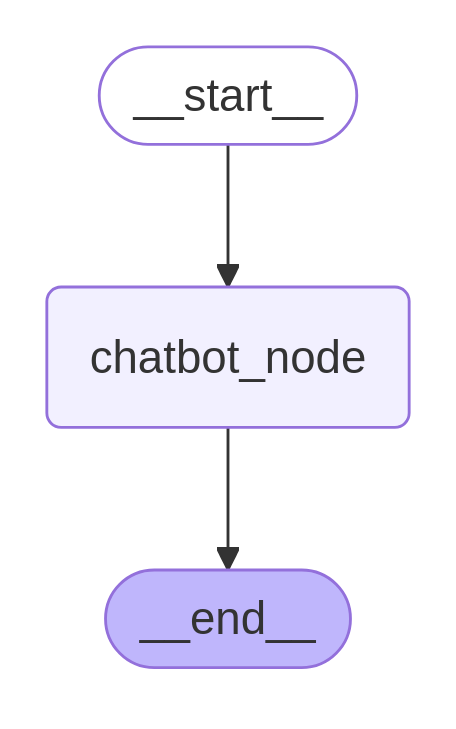

In [25]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage
from dotenv import load_dotenv
load_dotenv()

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    
    
# This is a simple chatbot that uses the LLM to respond to user input.
# It maintains a conversation history in the state.
def chatbot(state: AgentState) -> AgentState:
    return {
        "messages": llm.invoke(state["messages"])
    }
    
builder = StateGraph(AgentState)

builder.add_node("chatbot_node", chatbot)

builder.set_entry_point("chatbot_node")
builder.set_finish_point("chatbot_node")

graph = builder.compile()

show_graph(graph)

In [ ]:
state: AgentState = None
while True:
    user_input = input("You: ")
    
    if user_input in ["exit", "quit", "q"]:
        break
    
    if state is None:
        state = {
            "messages": []
        }
        state["messages"].append(SystemMessage(content="You're a helpful assistant."))
        
    state["messages"].append(HumanMessage(content=user_input))
    state = graph.invoke(state)
    llm_response = state["messages"][-1].content
    print(llm_response, flush=True)
    
    


    


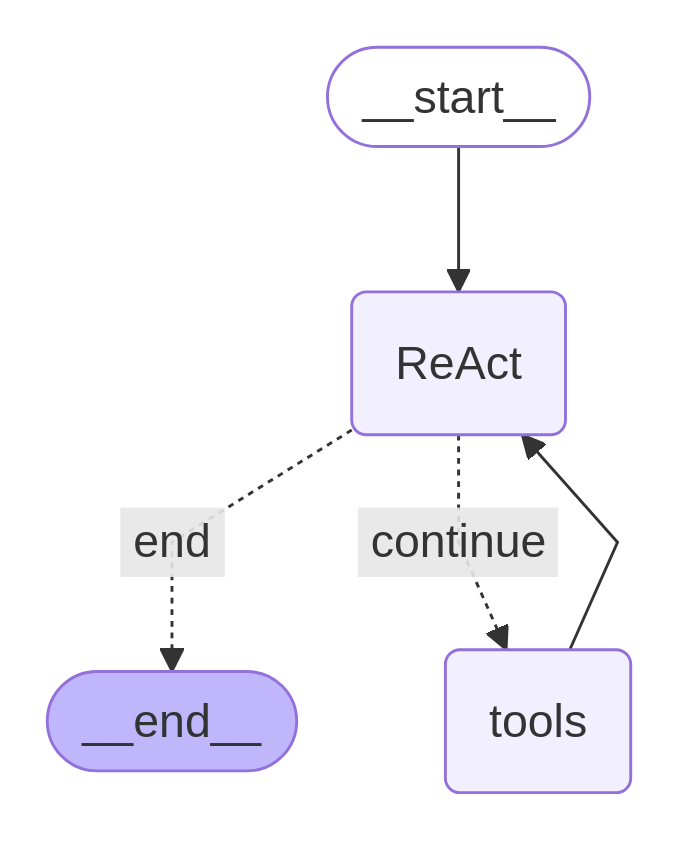

In [ ]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool
from langchain_community.tools import BraveSearch
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain.chat_models import init_chat_model
from datetime import datetime
import os

load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Initialize Python REPL tool
python_repl = PythonREPLTool()

# Initialize BraveSearch tool
brave_search = BraveSearch.from_api_key(
    api_key=os.getenv("BRAVE_SEARCH_API_KEY"),
    search_kwargs={"count": 3}
)

tools = [python_repl, brave_search]

model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")
model = model.bind_tools(tools)  # Bind the tools to the model

def model_call(state: AgentState) -> AgentState:
    current_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    system_prompt = SystemMessage(content=
        f"""You are a helpful AI assistant with access to Python code execution and web search capabilities.

        Current date and time: {current_date}

        Use the Python REPL tool when you need to:
        - Perform calculations
        - Learn the current date and time
        - Execute Python code for data processing with the built-in Python REPL
        
        Use the brave_search web search tool when you need to:
        - Find current information
        - Research topics
        - Get real-time data or news
        - Make sure you know the current date and time and make your search accordingly.

        Always explain your reasoning and provide clear, helpful responses.
        Please try your best until you find the answer or exhaust all options.
        """
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"

# Build the graph
graph = StateGraph(AgentState)
graph.add_node("ReAct", model_call)

tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("ReAct")

graph.add_conditional_edges(
    "ReAct",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

graph.add_edge("tools", "ReAct")

app = graph.compile()

show_graph(app)


In [24]:

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [HumanMessage(content="Türkiyede şu anki asgari ücretin kaç tl olduğunu öğren" +
                                    " ve bir asgari ücretli çalışanın yıllık toplam kazancını hesapla.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Türkiyede şu anki asgari ücretin kaç tl olduğunu öğren ve bir asgari ücretli çalışanın yıllık toplam kazancını hesapla.


KeyboardInterrupt: 